In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('bank.csv', sep=';', header = True, inferSchema = True)


df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()






root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [2]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

In [3]:
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [4]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)

In [5]:
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [12]:
df.select('label','features').show(truncate=False)

+-----+-----------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                         |
+-----+-----------------------------------------------------------------------------------------------------------------+
|0.0  |(30,[8,11,15,16,18,19,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,1787.0,79.0,1.0,-1.0])                |
|0.0  |(30,[4,11,13,16,17,19,22,24,25,26,27,28,29],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,33.0,4789.0,220.0,1.0,339.0,4.0])       |
|0.0  |(30,[0,12,14,16,17,18,19,22,24,25,26,27,28,29],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,35.0,1350.0,185.0,1.0,330.0,1.0])|
|0.0  |(30,[0,11,14,16,17,20,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,1476.0,199.0,4.0,-1.0])               |
|0.0  |(30,[1,11,13,16,17,18,20,21,24,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,59.0,226.0,1.0,-1.0])                  |
|0.0  |(30,[0,12,14,16,1

In [14]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,0,0,0,0,0
features,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,30,33,35,30,59
job,unemployed,services,management,management,blue-collar
marital,married,married,single,married,married
education,primary,secondary,tertiary,tertiary,secondary
default,no,no,no,no,no
balance,1787,4789,1350,1476,0
housing,no,yes,yes,yes,yes
loan,no,yes,no,yes,no


In [16]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 3173
Test Dataset Count: 1348


In [17]:
from pyspark.ml.classification import LogisticRegression

In [18]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)

In [19]:
lrModel = lr.fit(train)

In [22]:
#pip install matplotlib

import matplotlib.pyplot as plt
import numpy as np


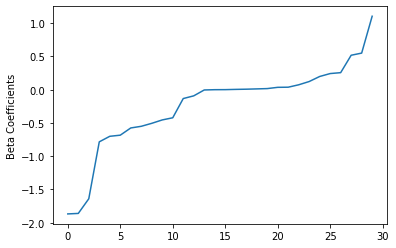

In [23]:
beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

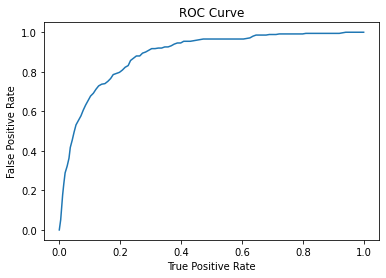

Training set areaUnderROC: 0.8871696776478928


In [24]:
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

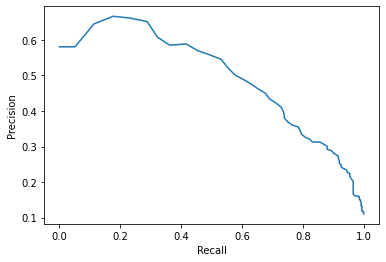

In [25]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

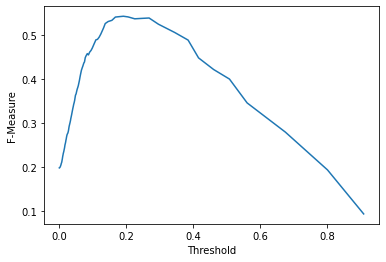

In [26]:
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

In [28]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(100)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[3.51342641415056...|       0.0|[0.97106738658008...|
| 34|management|  0.0|[3.35826661570623...|       0.0|[0.96637449620340...|
| 56|management|  0.0|[0.15206865663443...|       0.0|[0.53794407132858...|
| 40|management|  0.0|[3.46081178098929...|       0.0|[0.96955194043865...|
| 33|management|  0.0|[3.82215666145288...|       0.0|[0.97858794672810...|
| 36|management|  0.0|[4.02379947861651...|       0.0|[0.98242936626500...|
| 43|management|  0.0|[3.37027529246647...|       0.0|[0.96676253819658...|
| 48|management|  0.0|[3.33028886920122...|       0.0|[0.96545340570045...|
| 49|management|  0.0|[4.59227554826617...|       0.0|[0.98997180213091...|
| 52|management|  0.0|[4.16687744500451...|       0.0|[0.98473601465172...|
| 44|managem

In [29]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8723337655949569


In [30]:
evaluator.getMetricName()

'areaUnderROC'

In [31]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [32]:
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

In [33]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [35]:
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8705749079580852


In [36]:
evaluator.getMetricName()

'areaUnderROC'

# Decision Tree Classifier

Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions.

In [37]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)

In [38]:
predictions = dtModel.transform(test)

In [39]:
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 33|management|  0.0|[2662.0,214.0]|       0.0|[0.92559109874826...|
| 34|management|  0.0|[2662.0,214.0]|       0.0|[0.92559109874826...|
| 56|management|  0.0|   [91.0,43.0]|       0.0|[0.67910447761194...|
| 40|management|  0.0|[2662.0,214.0]|       0.0|[0.92559109874826...|
| 33|management|  0.0|[2662.0,214.0]|       0.0|[0.92559109874826...|
| 36|management|  0.0|[2662.0,214.0]|       0.0|[0.92559109874826...|
| 43|management|  0.0|[2662.0,214.0]|       0.0|[0.92559109874826...|
| 48|management|  0.0|[2662.0,214.0]|       0.0|[0.92559109874826...|
| 49|management|  0.0|[2662.0,214.0]|       0.0|[0.92559109874826...|
| 52|management|  0.0|[2662.0,214.0]|       0.0|[0.92559109874826...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

Evaluate our Decision Tree model

In [41]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.3711512567882464


In [42]:

evaluator.getMetricName()

'areaUnderROC'

One simple decision tree performed poorly because it is too weak given the range of different features. The prediction accuracy of decision trees can be improved by Ensemble methods.

# Random Forest Classifier

In [43]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)

In [44]:
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[18.7174300470765...|       0.0|[0.93587150235382...|
| 34|management|  0.0|[18.7174300470765...|       0.0|[0.93587150235382...|
| 56|management|  0.0|[14.2908005197425...|       0.0|[0.71454002598712...|
| 40|management|  0.0|[17.3282472119175...|       0.0|[0.86641236059587...|
| 33|management|  0.0|[19.0159801998780...|       0.0|[0.95079900999390...|
| 36|management|  0.0|[19.0159801998780...|       0.0|[0.95079900999390...|
| 43|management|  0.0|[19.0159801998780...|       0.0|[0.95079900999390...|
| 48|management|  0.0|[19.0159801998780...|       0.0|[0.95079900999390...|
| 49|management|  0.0|[19.0159801998780...|       0.0|[0.95079900999390...|
| 52|management|  0.0|[19.0159801998780...|       0.0|[0.95079900999390...|
+---+-------

Evaluate our Random Forest Classifier

In [45]:

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8354201135804675


In [46]:
evaluator.getMetricName()

'areaUnderROC'

# Gradient-boosted Tree Classifier

In [47]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)

In [48]:
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[1.21532705685181...|       0.0|[0.91913516358400...|
| 34|management|  0.0|[0.98853000118932...|       0.0|[0.87836740758035...|
| 56|management|  0.0|[0.25541202082856...|       0.0|[0.62499962919316...|
| 40|management|  0.0|[1.26786559017846...|       0.0|[0.92660905486563...|
| 33|management|  0.0|[1.06987730458291...|       0.0|[0.89470749542925...|
| 36|management|  0.0|[1.24664062146438...|       0.0|[0.92366946584406...|
| 43|management|  0.0|[1.14247446436973...|       0.0|[0.90762282095276...|
| 48|management|  0.0|[1.06987730458291...|       0.0|[0.89470749542925...|
| 49|management|  0.0|[1.29372361571814...|       0.0|[0.93004932238961...|
| 52|management|  0.0|[1.27681611302830...|       0.0|[0.92781715216853...|
+---+-------

Evaluate Gradient Boosted Tree Classifier

In [54]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8563922550641682


In [55]:
evaluator.getMetricName()

'areaUnderROC'

we will try tuning this model with the ParamGridBuilder and the CrossValidator.

In [56]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8660858461645472